# Gerando polígonos de vias no município de São Paulo

A intenção desse notebook é demonstrar e fomentar técnicas de trabalho de geoprocessamento com linguaem de programação, tentando obter um polígono de vias do município de São Paulo utilizando as seguintes camadas do [Geosampa](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/_SBC.aspx) 

* [Logradouros](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=05_Sistema%20Vi%E1rio%5C%5CLogradouro%5C%5CShapefile%5C%5CSIRGAS_SHP_logradouronbl&arqTipo=Shapefile)
* [Quadras Viárias](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=11_Cadastro%5C%5CQuadra%5C%5CShapefile%5C%5CSIRGAS_SHP_quadraMDSF&arqTipo=Shapefile)

Para nossos primeiros experimentos vamos recortar ambas as camadas pela folha número 3316-221 do _SCM_ (Sistema Cartográfico Municipal). Esses arquivos processados estão na pasta gis desse projeto. 

## Trabalhando com o Geopandas

Inicialmente optamos por trabalhar com os dados georeferenciados dentro do banco de dados PostGis. Para isso é necessário importar os Shapefiles para dentro do banco. Neste post é possível aprender [3 maneiras de importar ShapeFiles para dentro do banco de dados PostGis](http://www.clickgeo.com.br/formas-de-importar-shapes-postgis/)

Porém acabamos reconhecendo que o Geopandas possui basstante maturidade, eficácia e performance para trabalhar com grandes quantidade de dados e portanto acabamos não tendo a necessidade de utilizar o PostGis para esse geoprecessamento por enquanto.

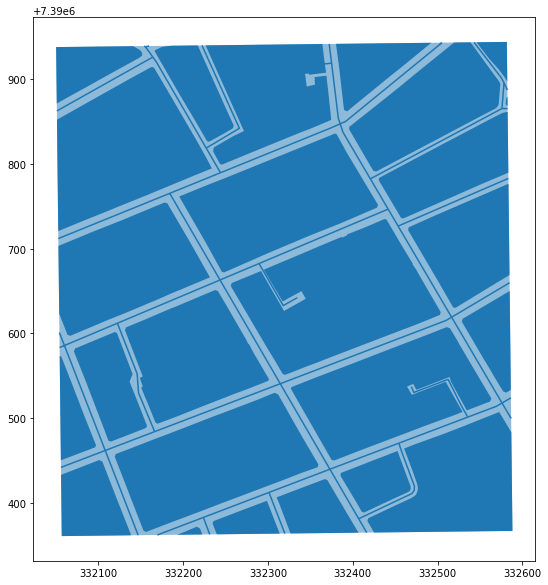

In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (20, 10)


df_scm = gpd.read_file('./gis/scm-3316-221.geojson')
df_quadras = gpd.read_file('./gis/quadras-3316-221.geojson')
df_logradouros = gpd.read_file('./gis/logradouros-3316-221.geojson')

f, ax = plt.subplots(1)
df_scm.plot(ax=ax, alpha=0.5)
df_quadras.plot(ax=ax)
df_logradouros.plot(ax=ax)

plt.show()



### Gerando as diferenças entre as feições do SCM com a quadra

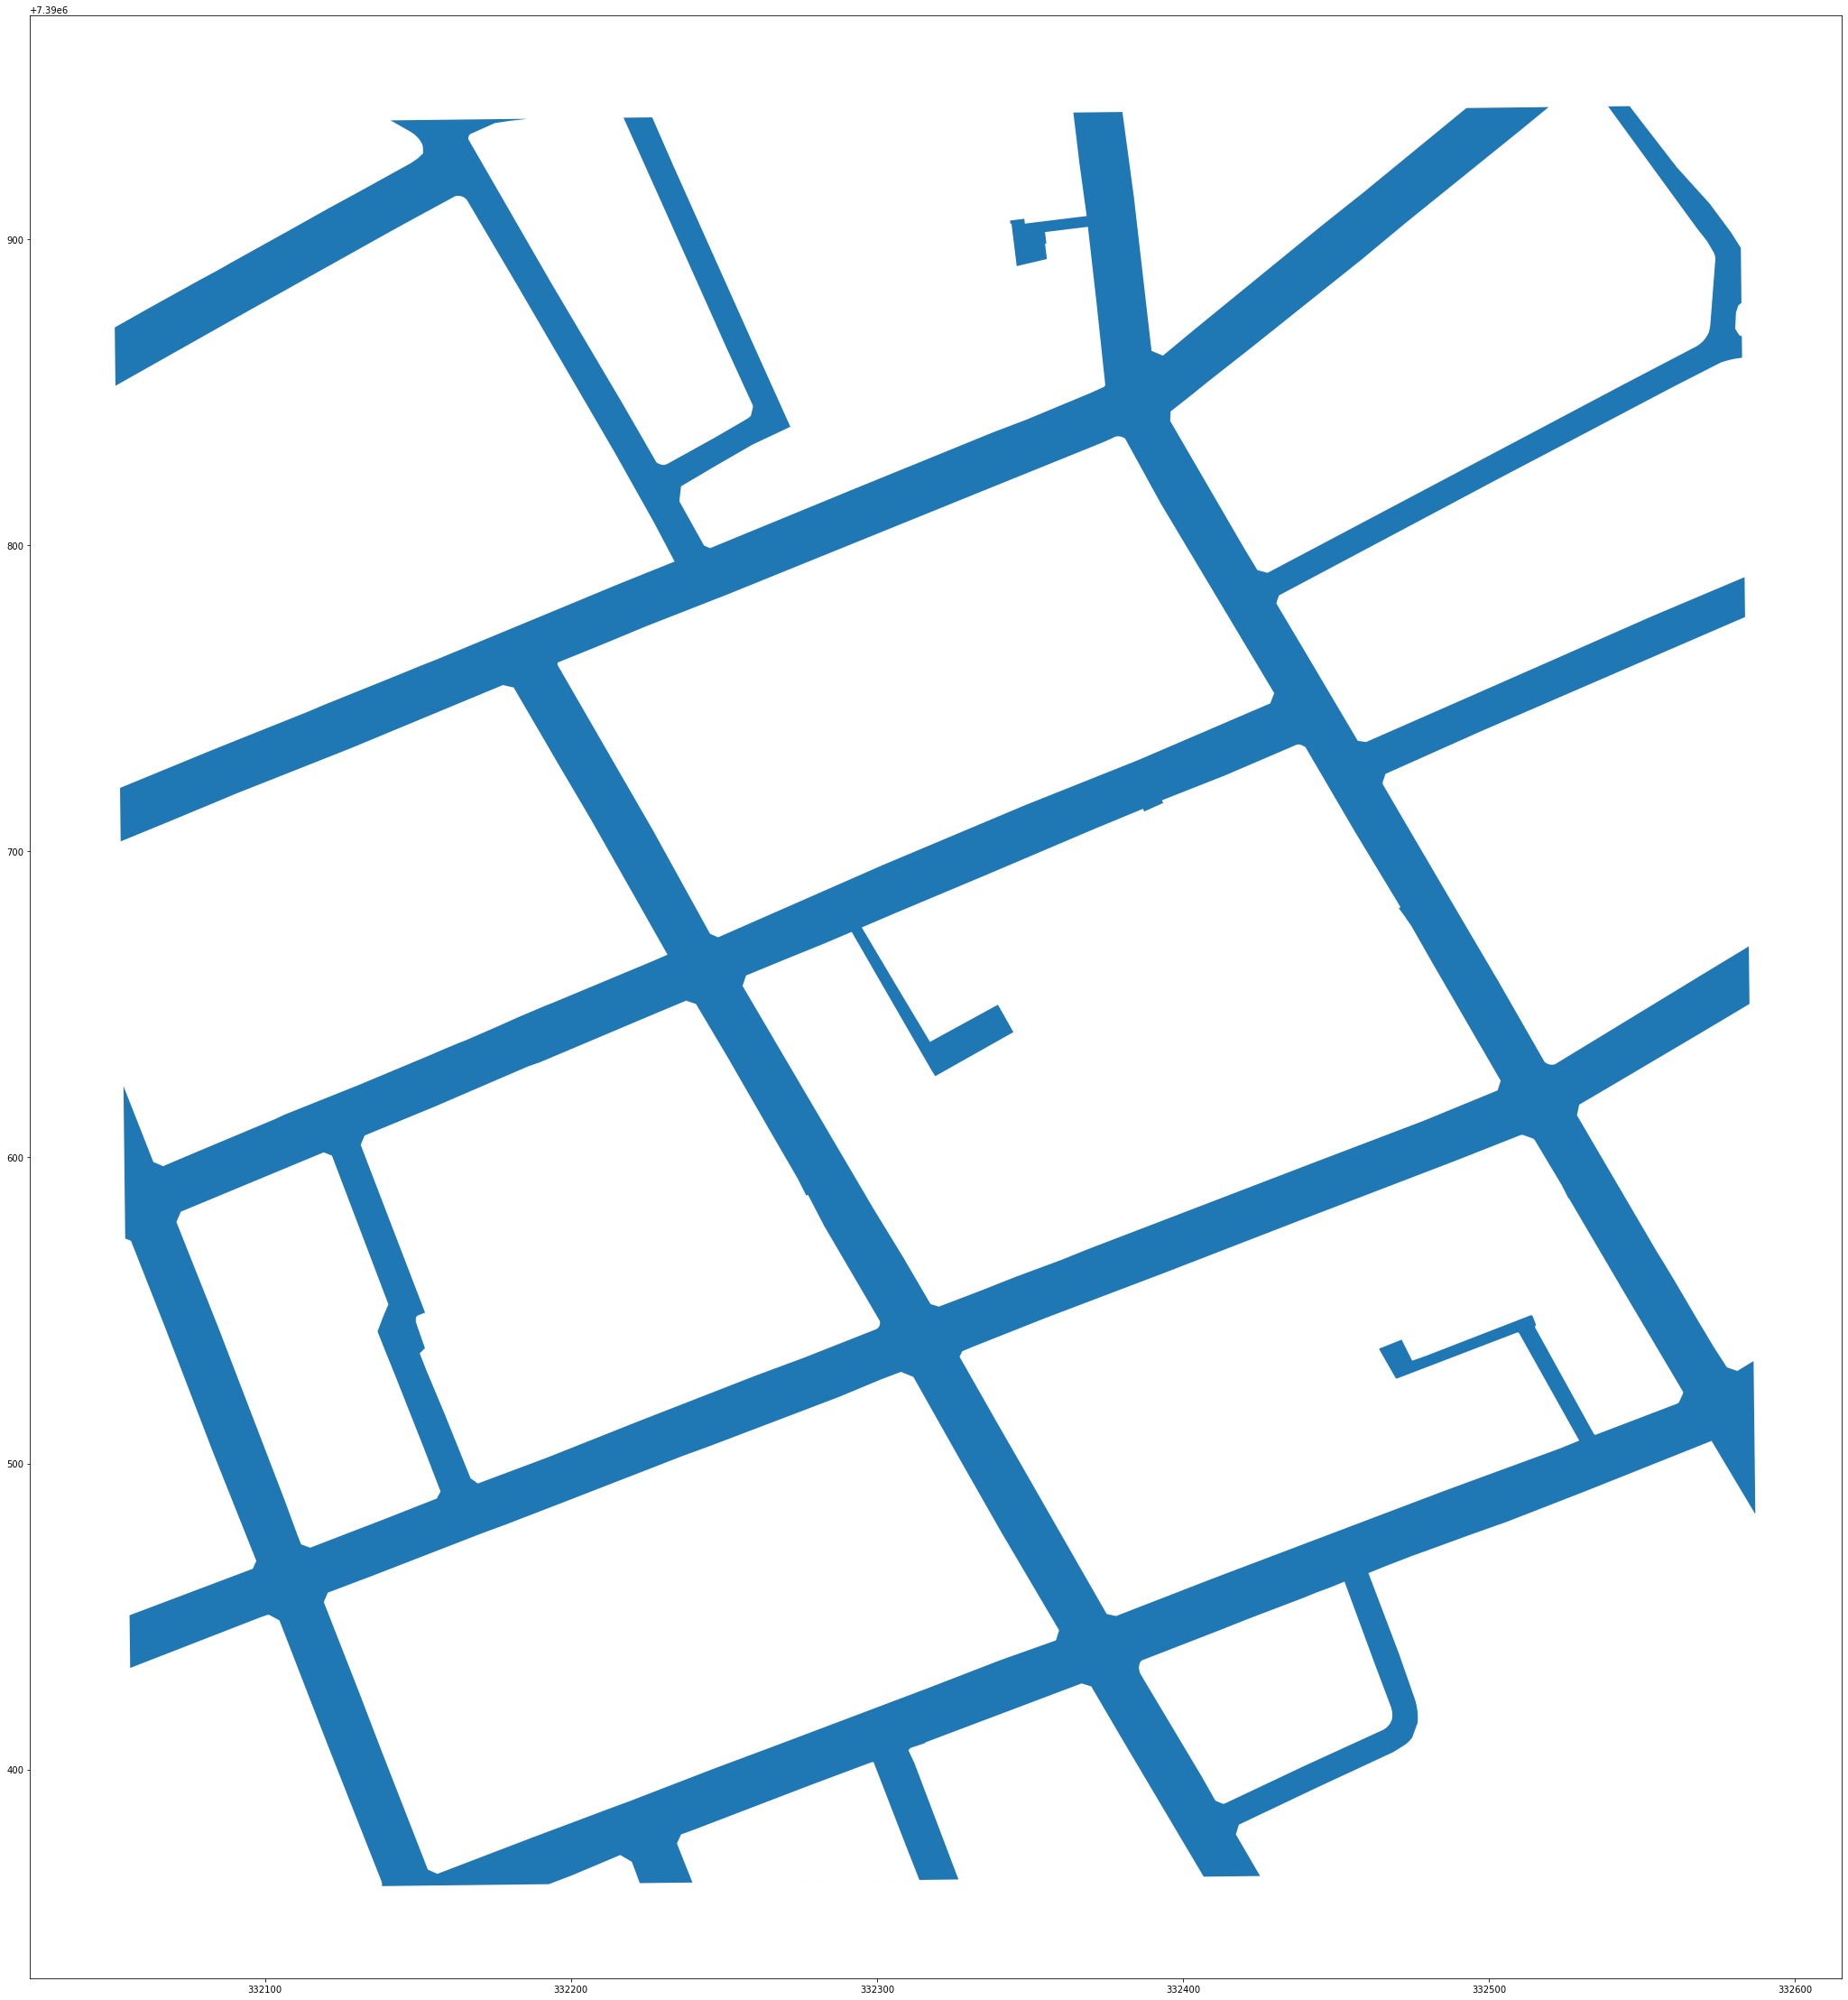

In [3]:
df_vias = gpd.overlay(df_scm, df_quadras, how='difference')
plt.rcParams['figure.figsize'] = (40, 40)
df_vias.plot()

## Definindo uma nova estratégia

Como o MedialAxis não funcionou com uma quantidade essa quantidade de rings no polígono provavelmente vamos ter que descarta-lo e utilizar as próprias linhas do traçado do viário para recortar esse polígono

### capturando os pontos iniciais de conexão de logradouros

In [5]:
#df_cruzamentos = gpd.GeoDataFrame.from_postgis(sql=sql_cruzamentos, con=engine)

#f, ax = plt.subplots(1)
#df_vias.plot(ax=ax, alpha=0.5)
#df_cruzamentos.plot(ax=ax)
#df_logradouros.plot(ax=ax)

#plt.show()

Obtendo os pontos finais e iniciais de cada logradouro podemos saber onde as ruas começam e terminam

In [6]:
gdf_cruzamentos_inicio = df_logradouros['geometry'].map(lambda x: (x.interpolate(0, normalized=True)))
gdf_cruzamentos_final = df_logradouros['geometry'].map(lambda x: (x.interpolate(1, normalized=True)))
gdf_cruzamentos =  pd.concat([gdf_cruzamentos_inicio, gdf_cruzamentos_final])

Como alguns pontos acabam ficando muito próximos, seria interessante agregar todos os pontos do cruzamento.

In [7]:
cruzamentos = [p.centroid for p in gdf_cruzamentos.buffer(10).unary_union]
ds_cruzamentos = gpd.GeoSeries(cruzamentos)
ds_cruzamentos.crs = {'init': 'epsg:31983'}

Vamos ver o que temos até agora

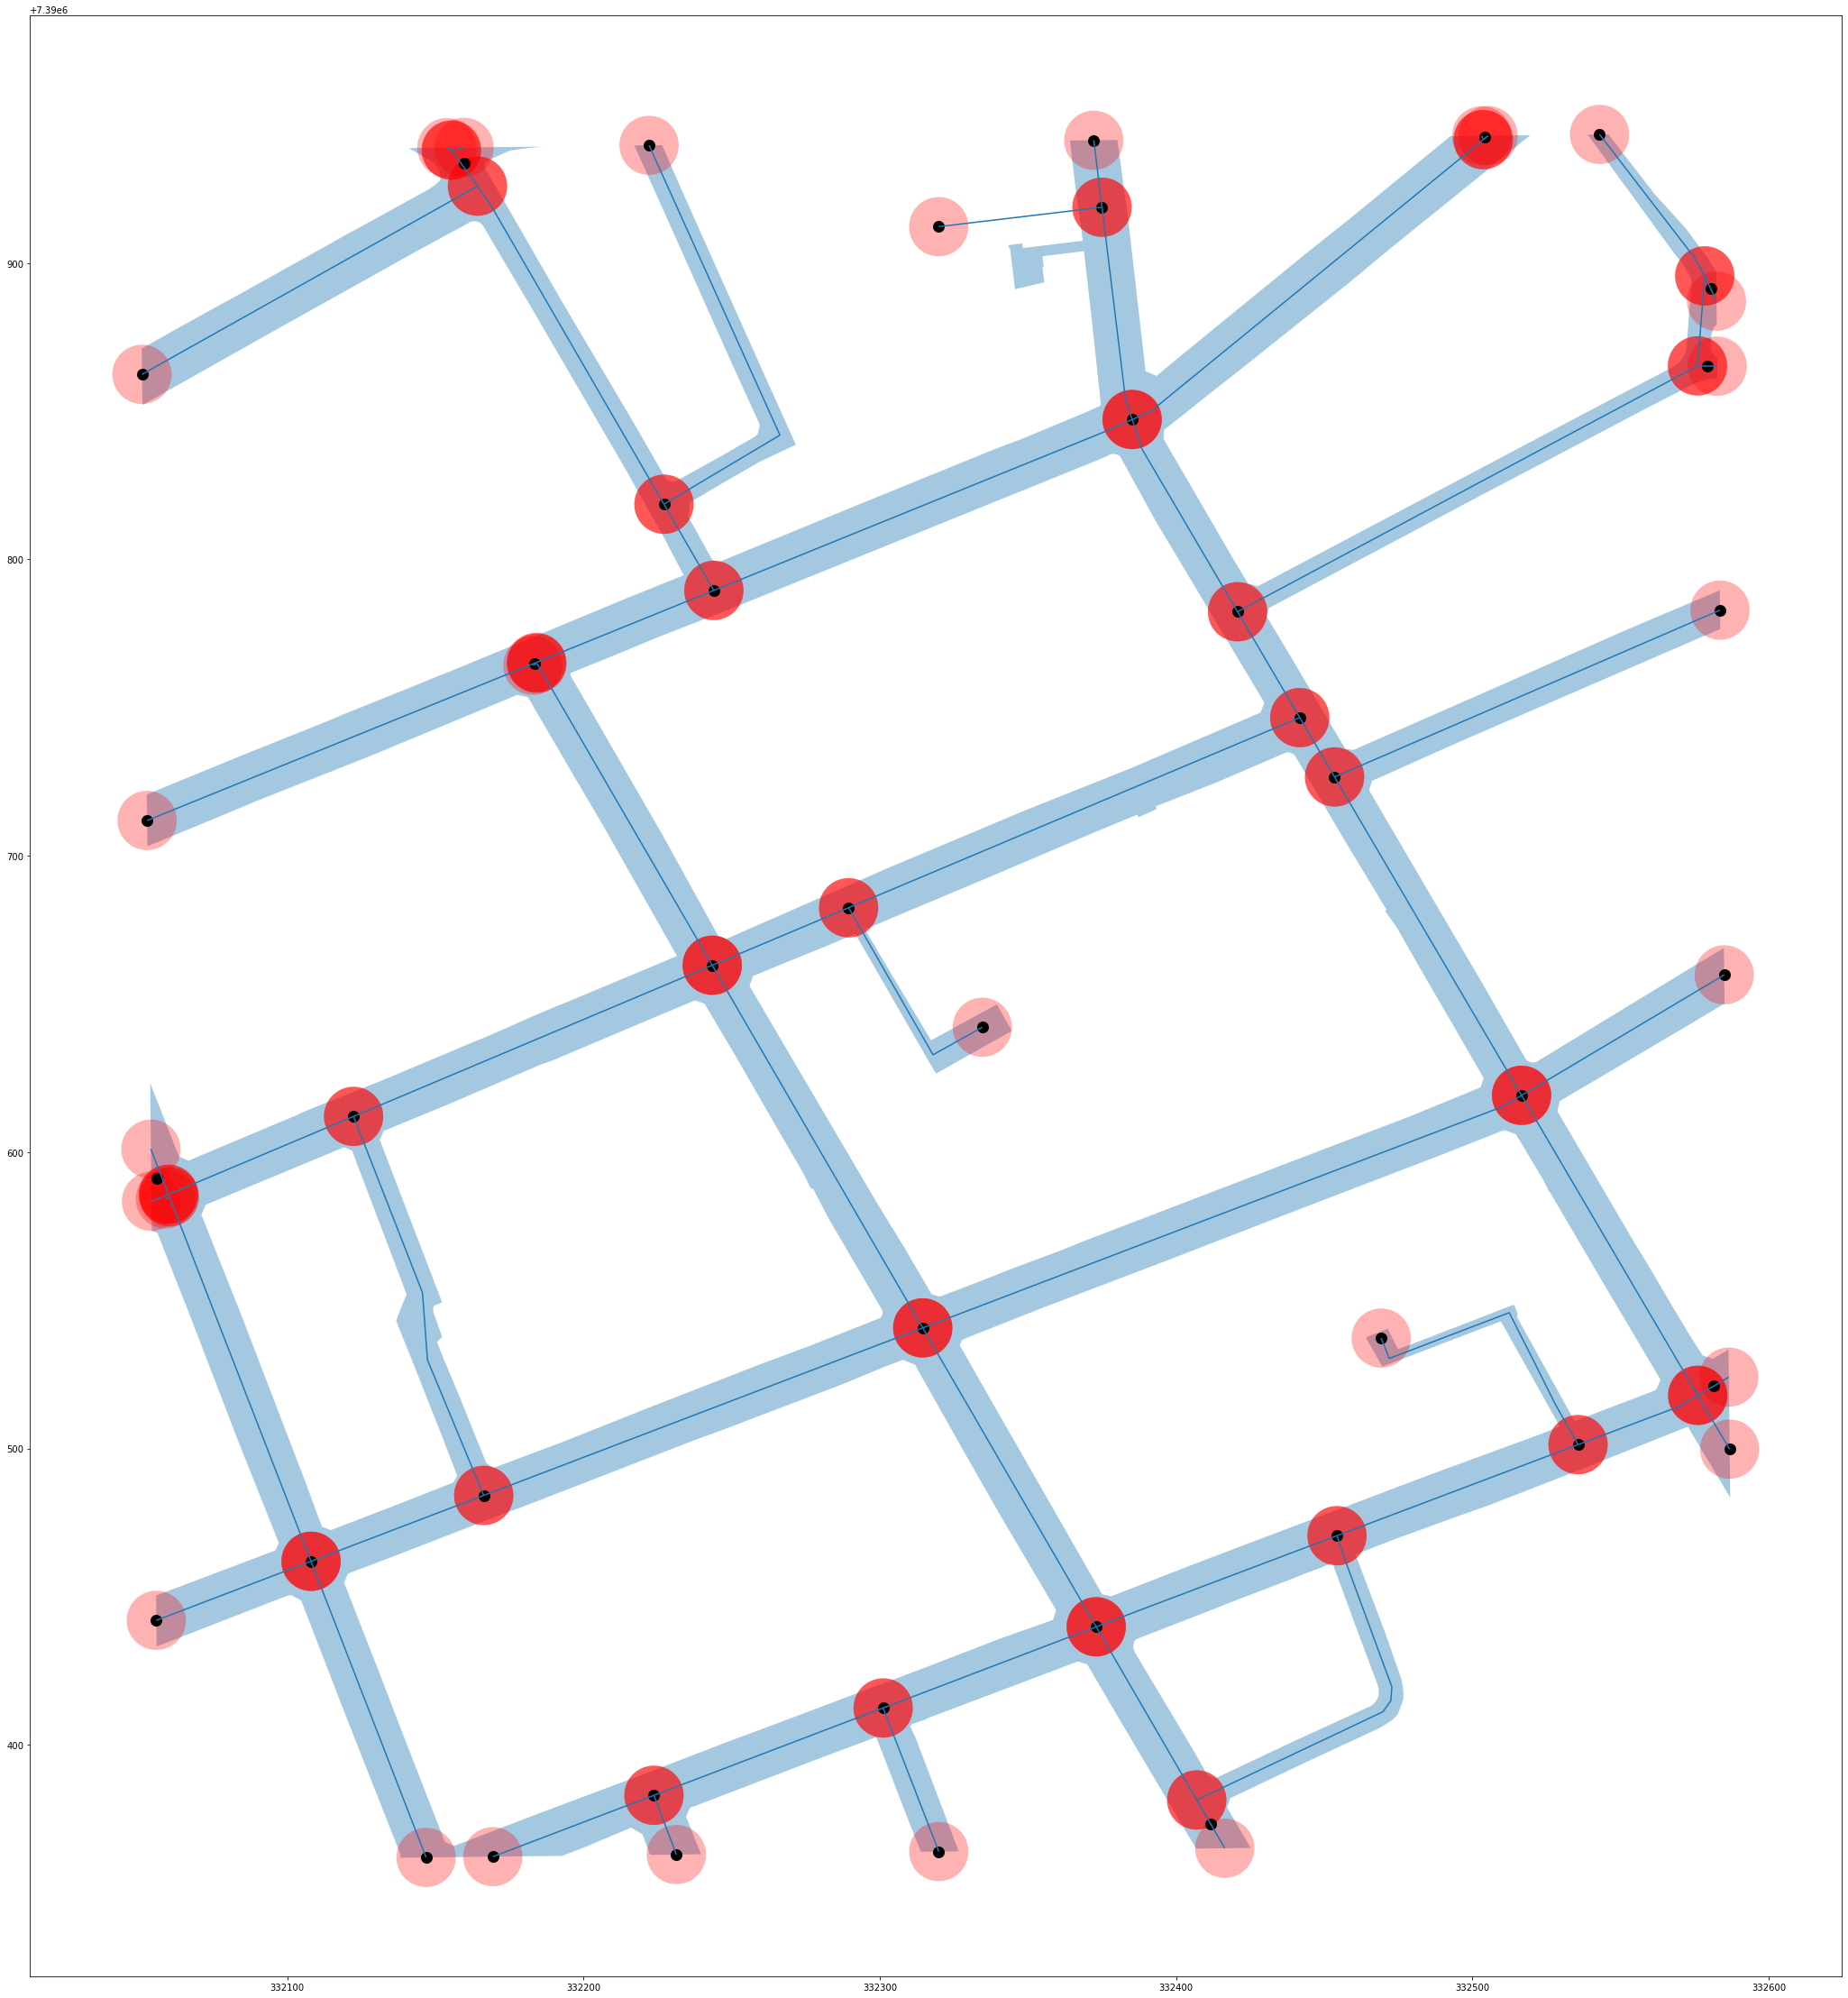

In [8]:
df_cruz_buffer = gdf_cruzamentos.geometry.map(lambda x: x.buffer(10))

f, ax = plt.subplots(1)
df_vias.plot(ax=ax, alpha=0.4)
df_logradouros.plot(ax=ax)
df_cruz_buffer.plot(ax=ax, alpha=0.3, color='red')
ds_cruzamentos.plot(ax=ax, lw=7, color='black')

plt.show()

## Criando linhas para 'cortar' os polígonos

Agora que temos que cortar o polígono precisamos de linhas para realizar esse fatiamento. 
Primeiramente vamos criar uma intersecção dos buffers dos nós com o traçado dos logradouros

In [9]:
from shapely.geometry import Polygon, Point, MultiPoint, LineString, MultiLineString

Porém antes vamos testar nossa estratégia em uma feição hipotética para fixar o conhecimento ...

In [11]:
%%time

from shapely.ops import split
from math import atan2, degrees
from shapely.affinity import rotate, scale

# criando um polígono de cruzamento hipotético
poligono =  Point((0,0)).buffer(1)
df_poligono = gpd.GeoDataFrame([0], geometry=[poligono])

Wall time: 0 ns


In [12]:
# criando linhas de traçado viário hipotéticas
linha1 = LineString([Point(0, 0), Point(2, 2)])
linha2 = LineString([Point(0, 0), Point(-1, 2)])
linha3 = LineString([Point(-0.1, -0.1), Point(1, -2)])
df_linha = gpd.GeoDataFrame([0, 1, 2], geometry=[linha1, linha2, linha3])

inter_poligono_linha = df_linha.unary_union.intersection(df_poligono.unary_union)
df_inter_poligono_linha = gpd.GeoDataFrame([0], geometry=[inter_poligono_linha])

inter_ponto_borda = df_poligono.boundary.intersection(df_linha.unary_union)
df_inter_ponto_borda = gpd.GeoDataFrame([0], geometry=inter_ponto_borda)
cx, cy = df_poligono.geometry.centroid.x, df_poligono.geometry.centroid.y
angulos = [degrees(atan2(point.y - cy, point.x - cx)) for point in inter_ponto_borda[0]]
print(angulos)


nova_linha = [LineString([Point(0,0), point]) for point in inter_ponto_borda[0]]
df_nova_linha = gpd.GeoDataFrame(list(range(len(nova_linha))), geometry=nova_linha)
df_nova_linha.columns = ['index', 'geometry']
df_nova_linha['geometry'] = df_nova_linha['geometry'].scale(xfact=1.5, yfact=1.5, origin=(0,0))


#rotacionar o poligono para que o ponto inicial coincida com algum segmento
poligono = rotate(poligono, angulos[0], origin=(cx, cy))
fatiado = split(poligono.boundary, df_nova_linha.unary_union)
fatias = [fatia for fatia in fatiado]
df_fatiado = gpd.GeoDataFrame(list(range(len(fatias))), geometry=fatias)
df_fatiado.columns = ['index', 'geometry']


ponto_medio = [fatia.interpolate(0.5, normalized=True) for fatia in fatiado]
df_ponto_medio = gpd.GeoDataFrame(list(range(len(ponto_medio))), geometry=ponto_medio)
df_ponto_medio.columns = ['index', 'geometry']


[116.56505117707799, -67.78708909885995, 45.0]


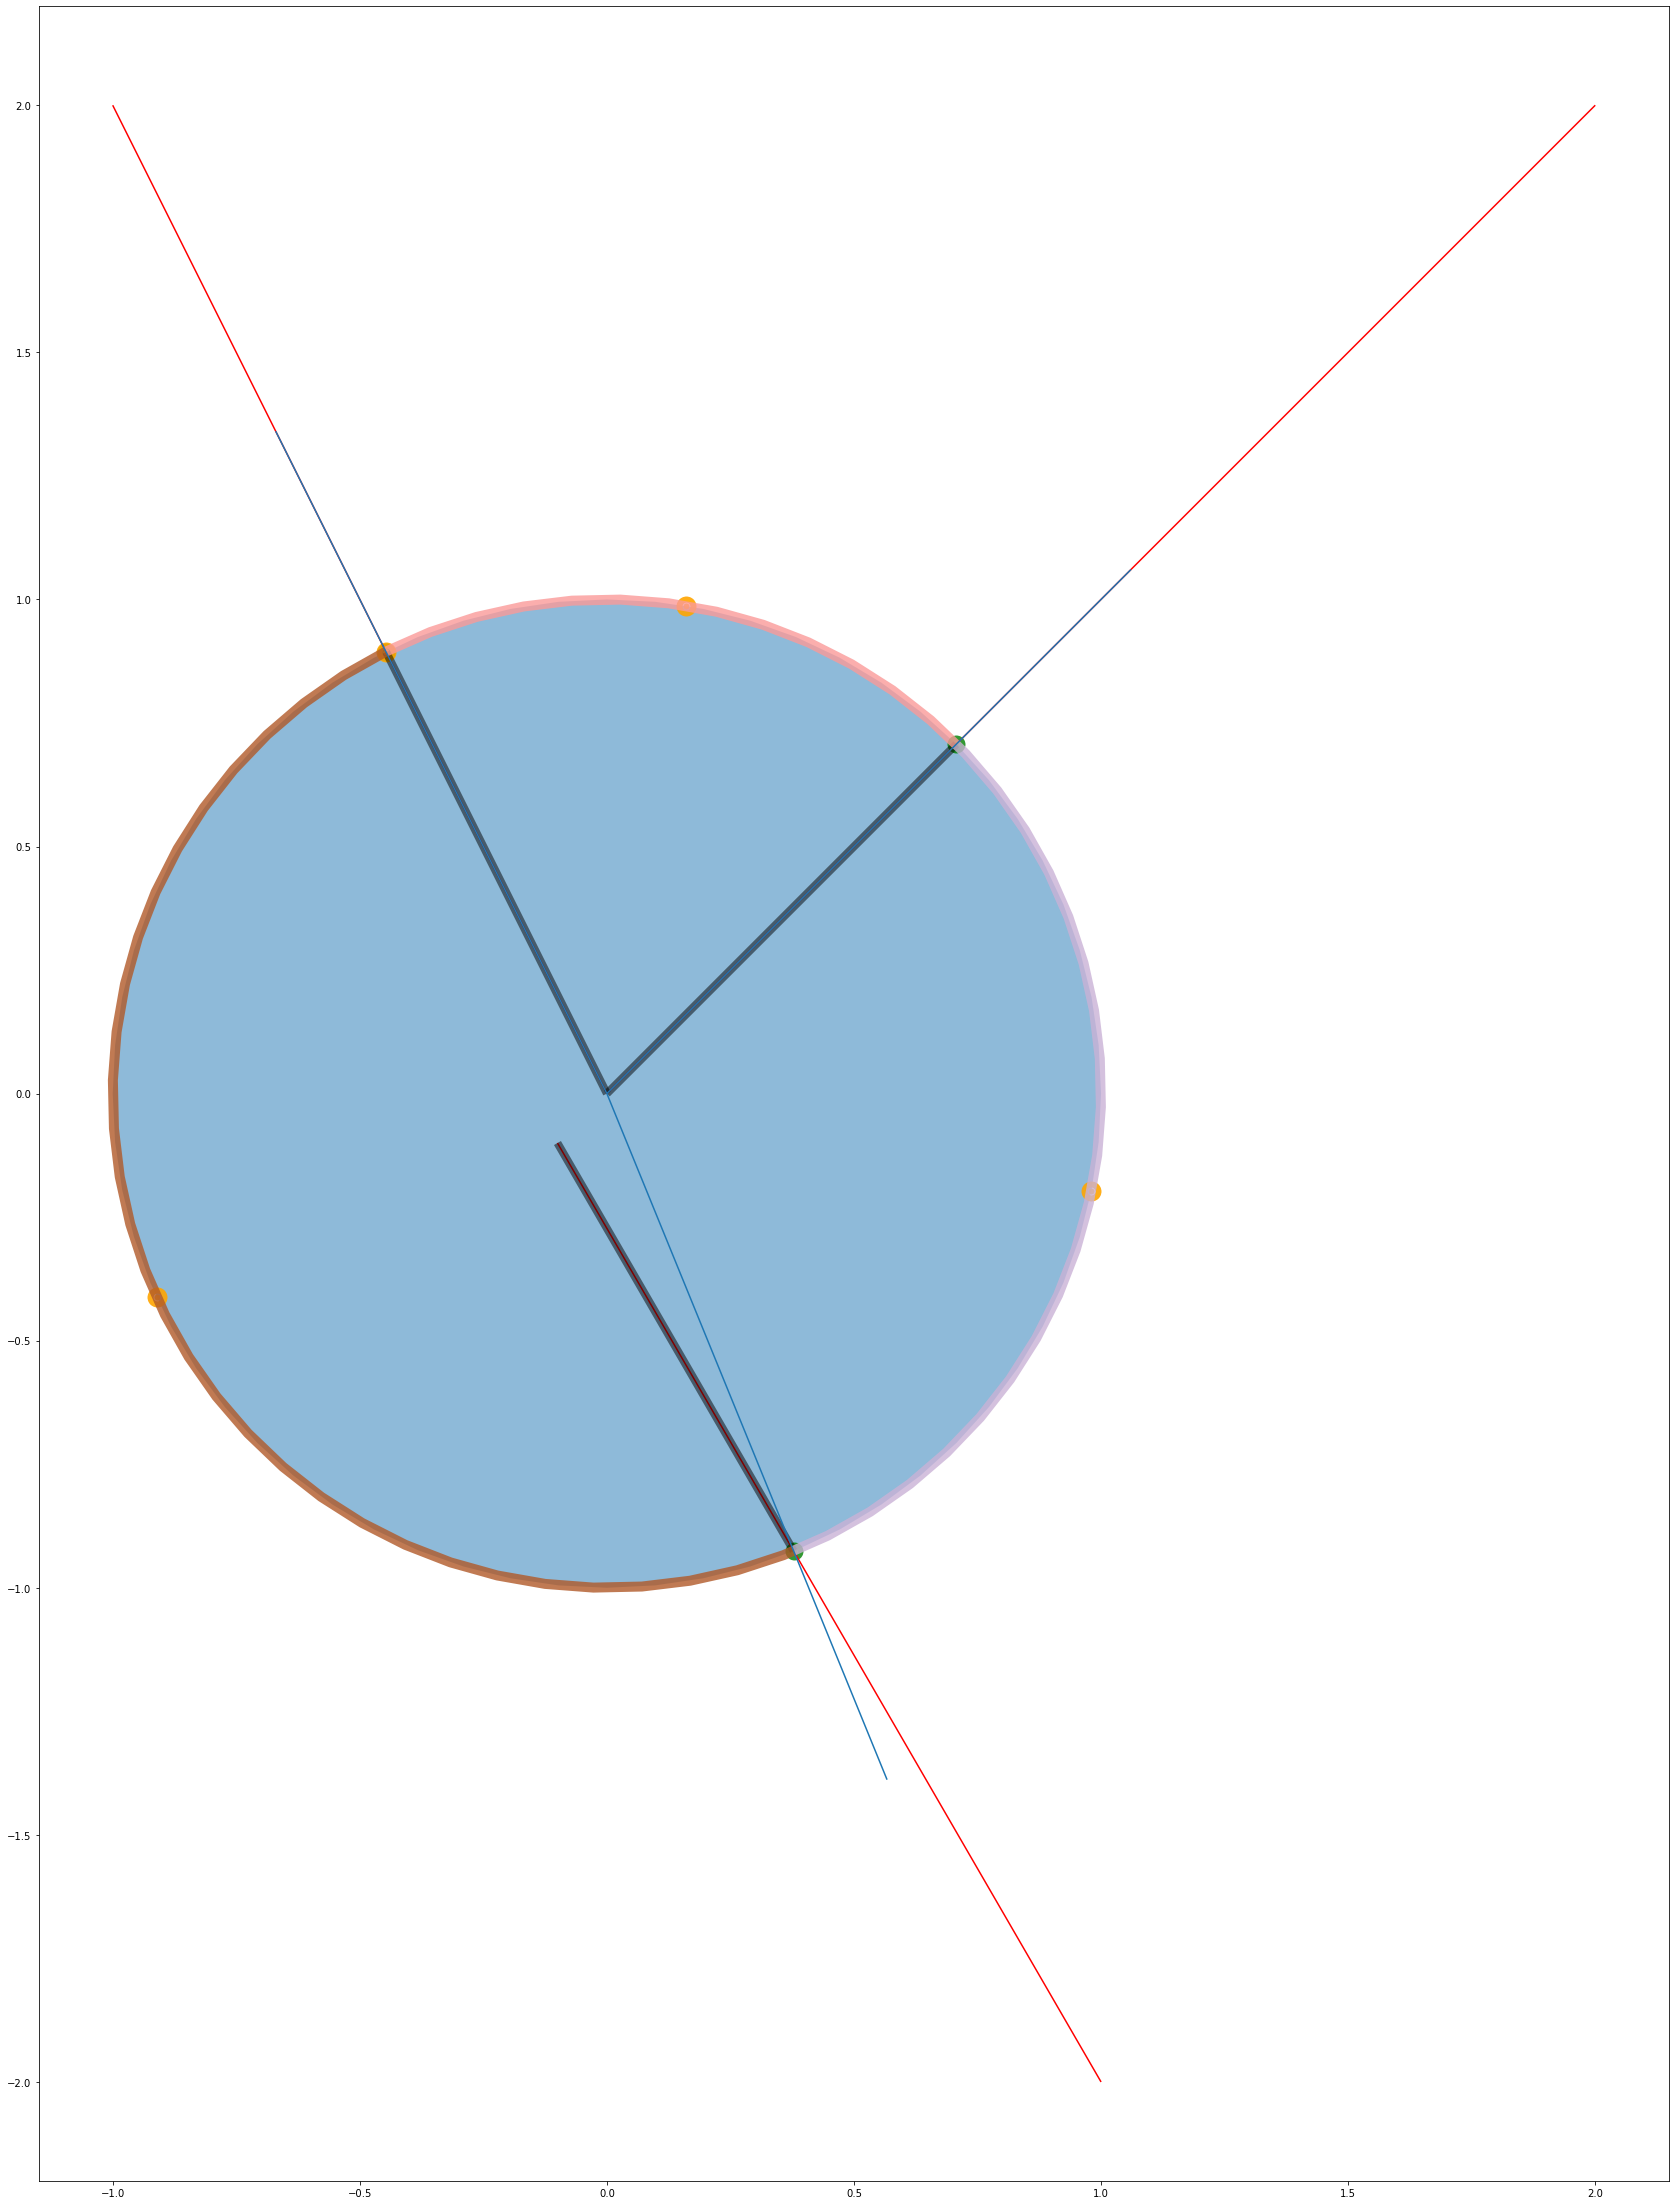

In [13]:
f, ax = plt.subplots(1)

df_poligono.plot(ax=ax, alpha=0.5)
df_linha.plot(ax=ax, color='red')
df_inter_poligono_linha.plot(ax=ax, color='black', alpha=0.5, linewidth=8)
df_inter_ponto_borda.plot(ax=ax, color='green', alpha=0.8, linewidth=12)
df_fatiado.plot(ax=ax, column='index', lw=3, cmap='Paired', alpha=0.8, linewidth=10)
df_nova_linha.plot(ax=ax)
df_ponto_medio.plot(ax=ax, color='orange', alpha=0.9, linewidth=14)

plt.show()

## Agora voltando a trabalhar nas feições

Agora que conseguimos realizar a estratégia de traçar um buffer ao redor do cruzamento e então gerar linhas nas bissetrizes do traçado do viário podemos repetir o mesmo nas nossas feições.
Relembrando o que temos até aqui:

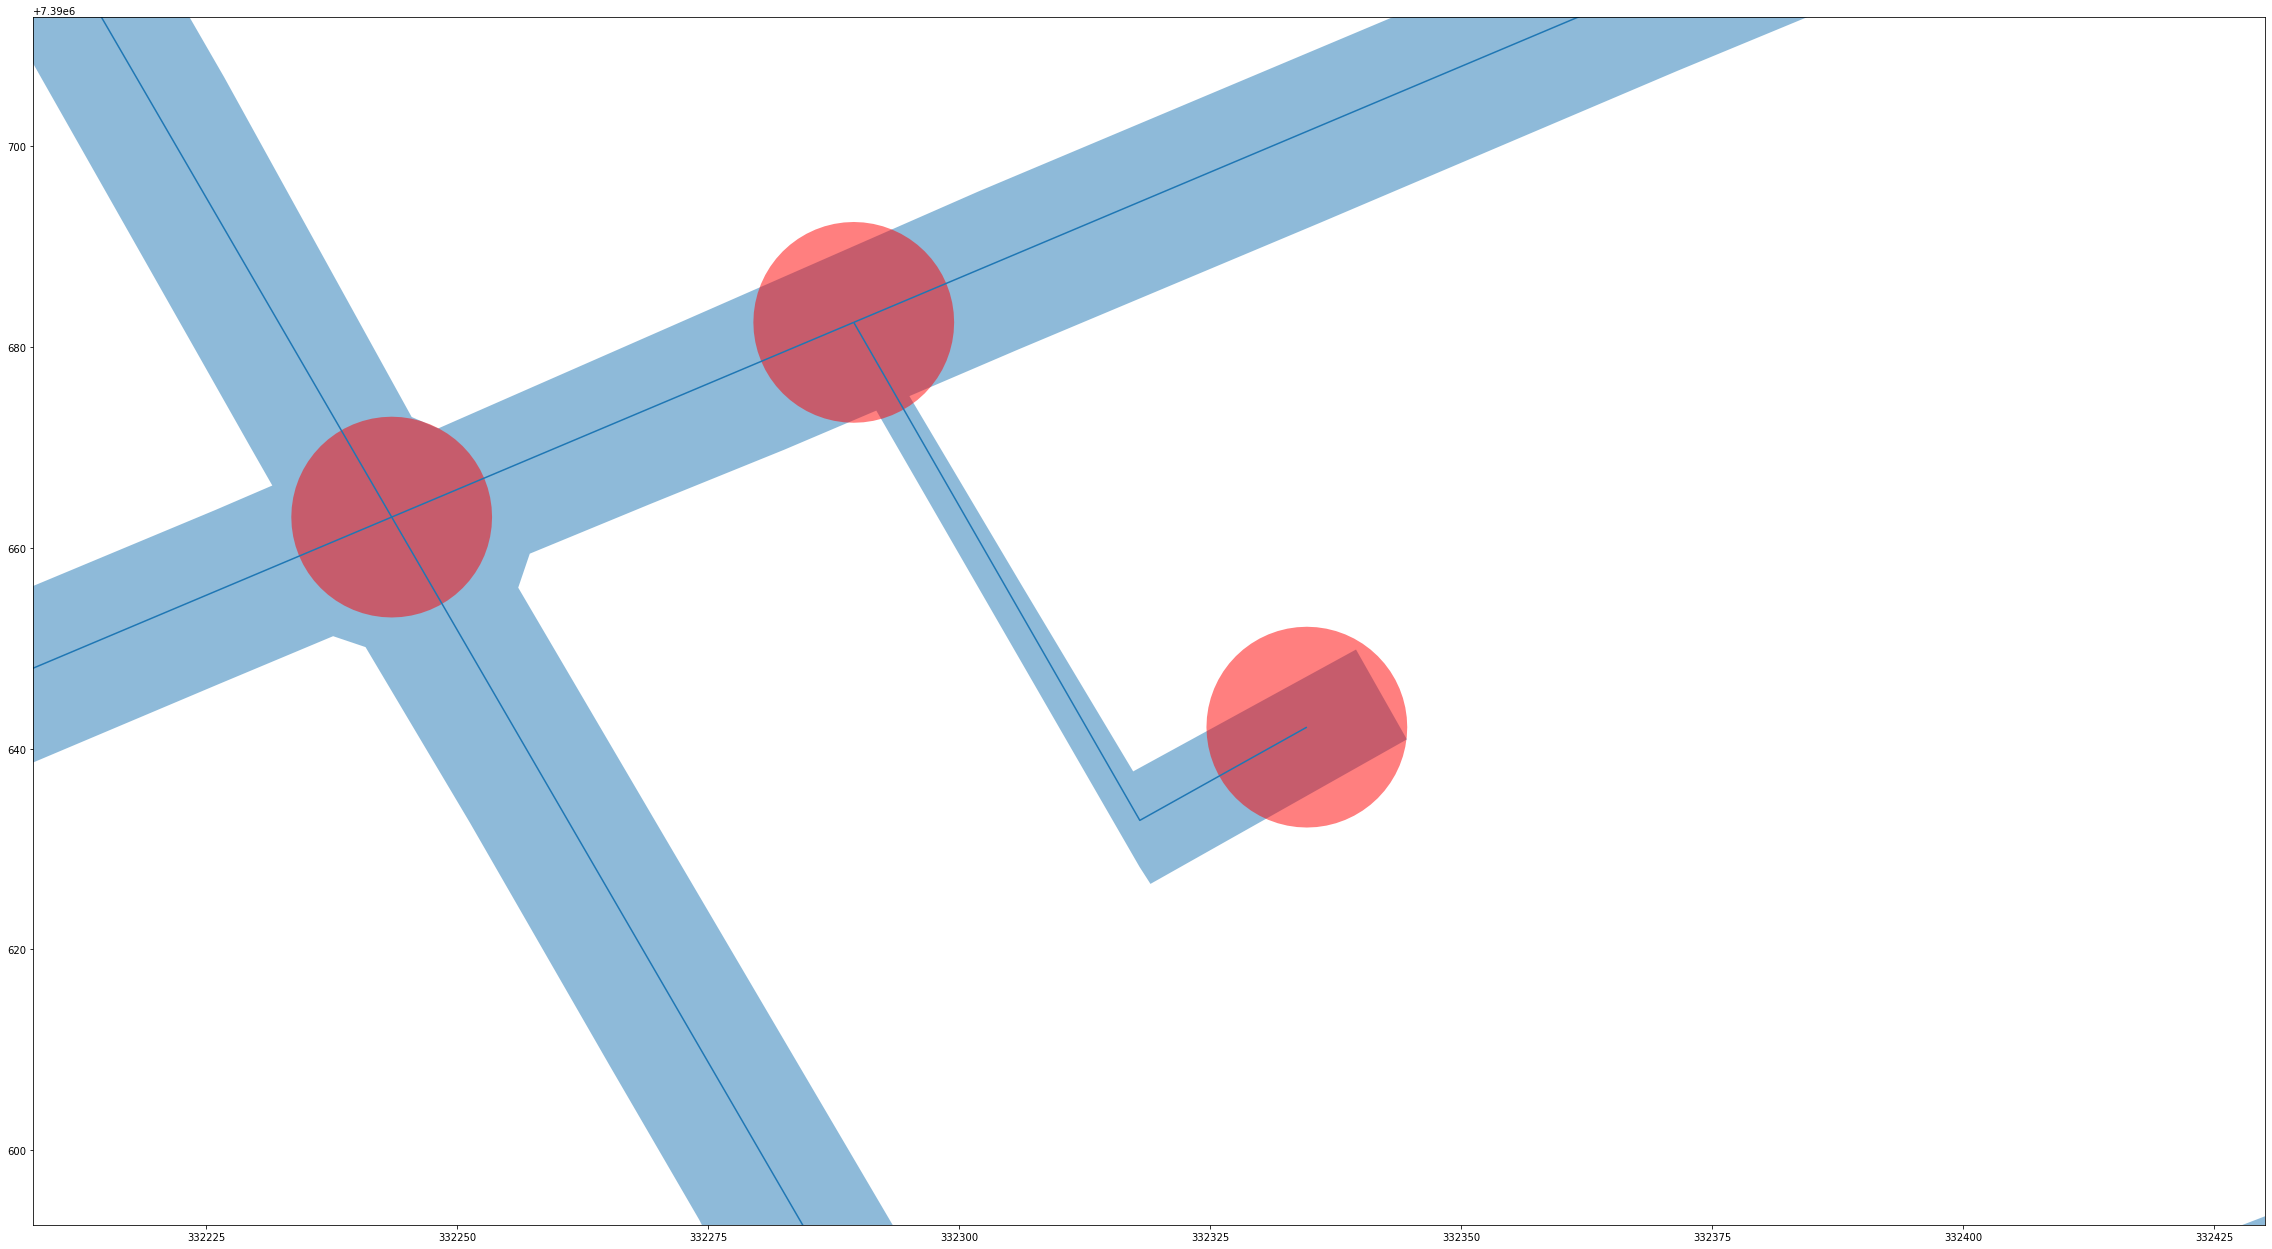

In [14]:
df_vias # nosso polígono de vias, totalmente unido
df_nos = gpd.GeoDataFrame(list(range(len(ds_cruzamentos))), geometry=ds_cruzamentos.buffer(10)) # os nós que vão nos balizar para fatiar o polígono de vias
df_nos.columns = ['index', 'geometry']
df_logradouros # o tracado dos logradouros

f, ax = plt.subplots(1)

# Aplicando o zoom
plt.margins(x=-0.30, y=-0.40)

df_vias.plot(ax=ax, alpha=0.5)
#df_cruzamentos.plot(ax=ax)
df_logradouros.plot(ax=ax)
df_nos.plot(ax=ax, alpha=0.5, color='red')

plt.show()

Vamos relacionar os logradouros que intersectcam cada um dos nós

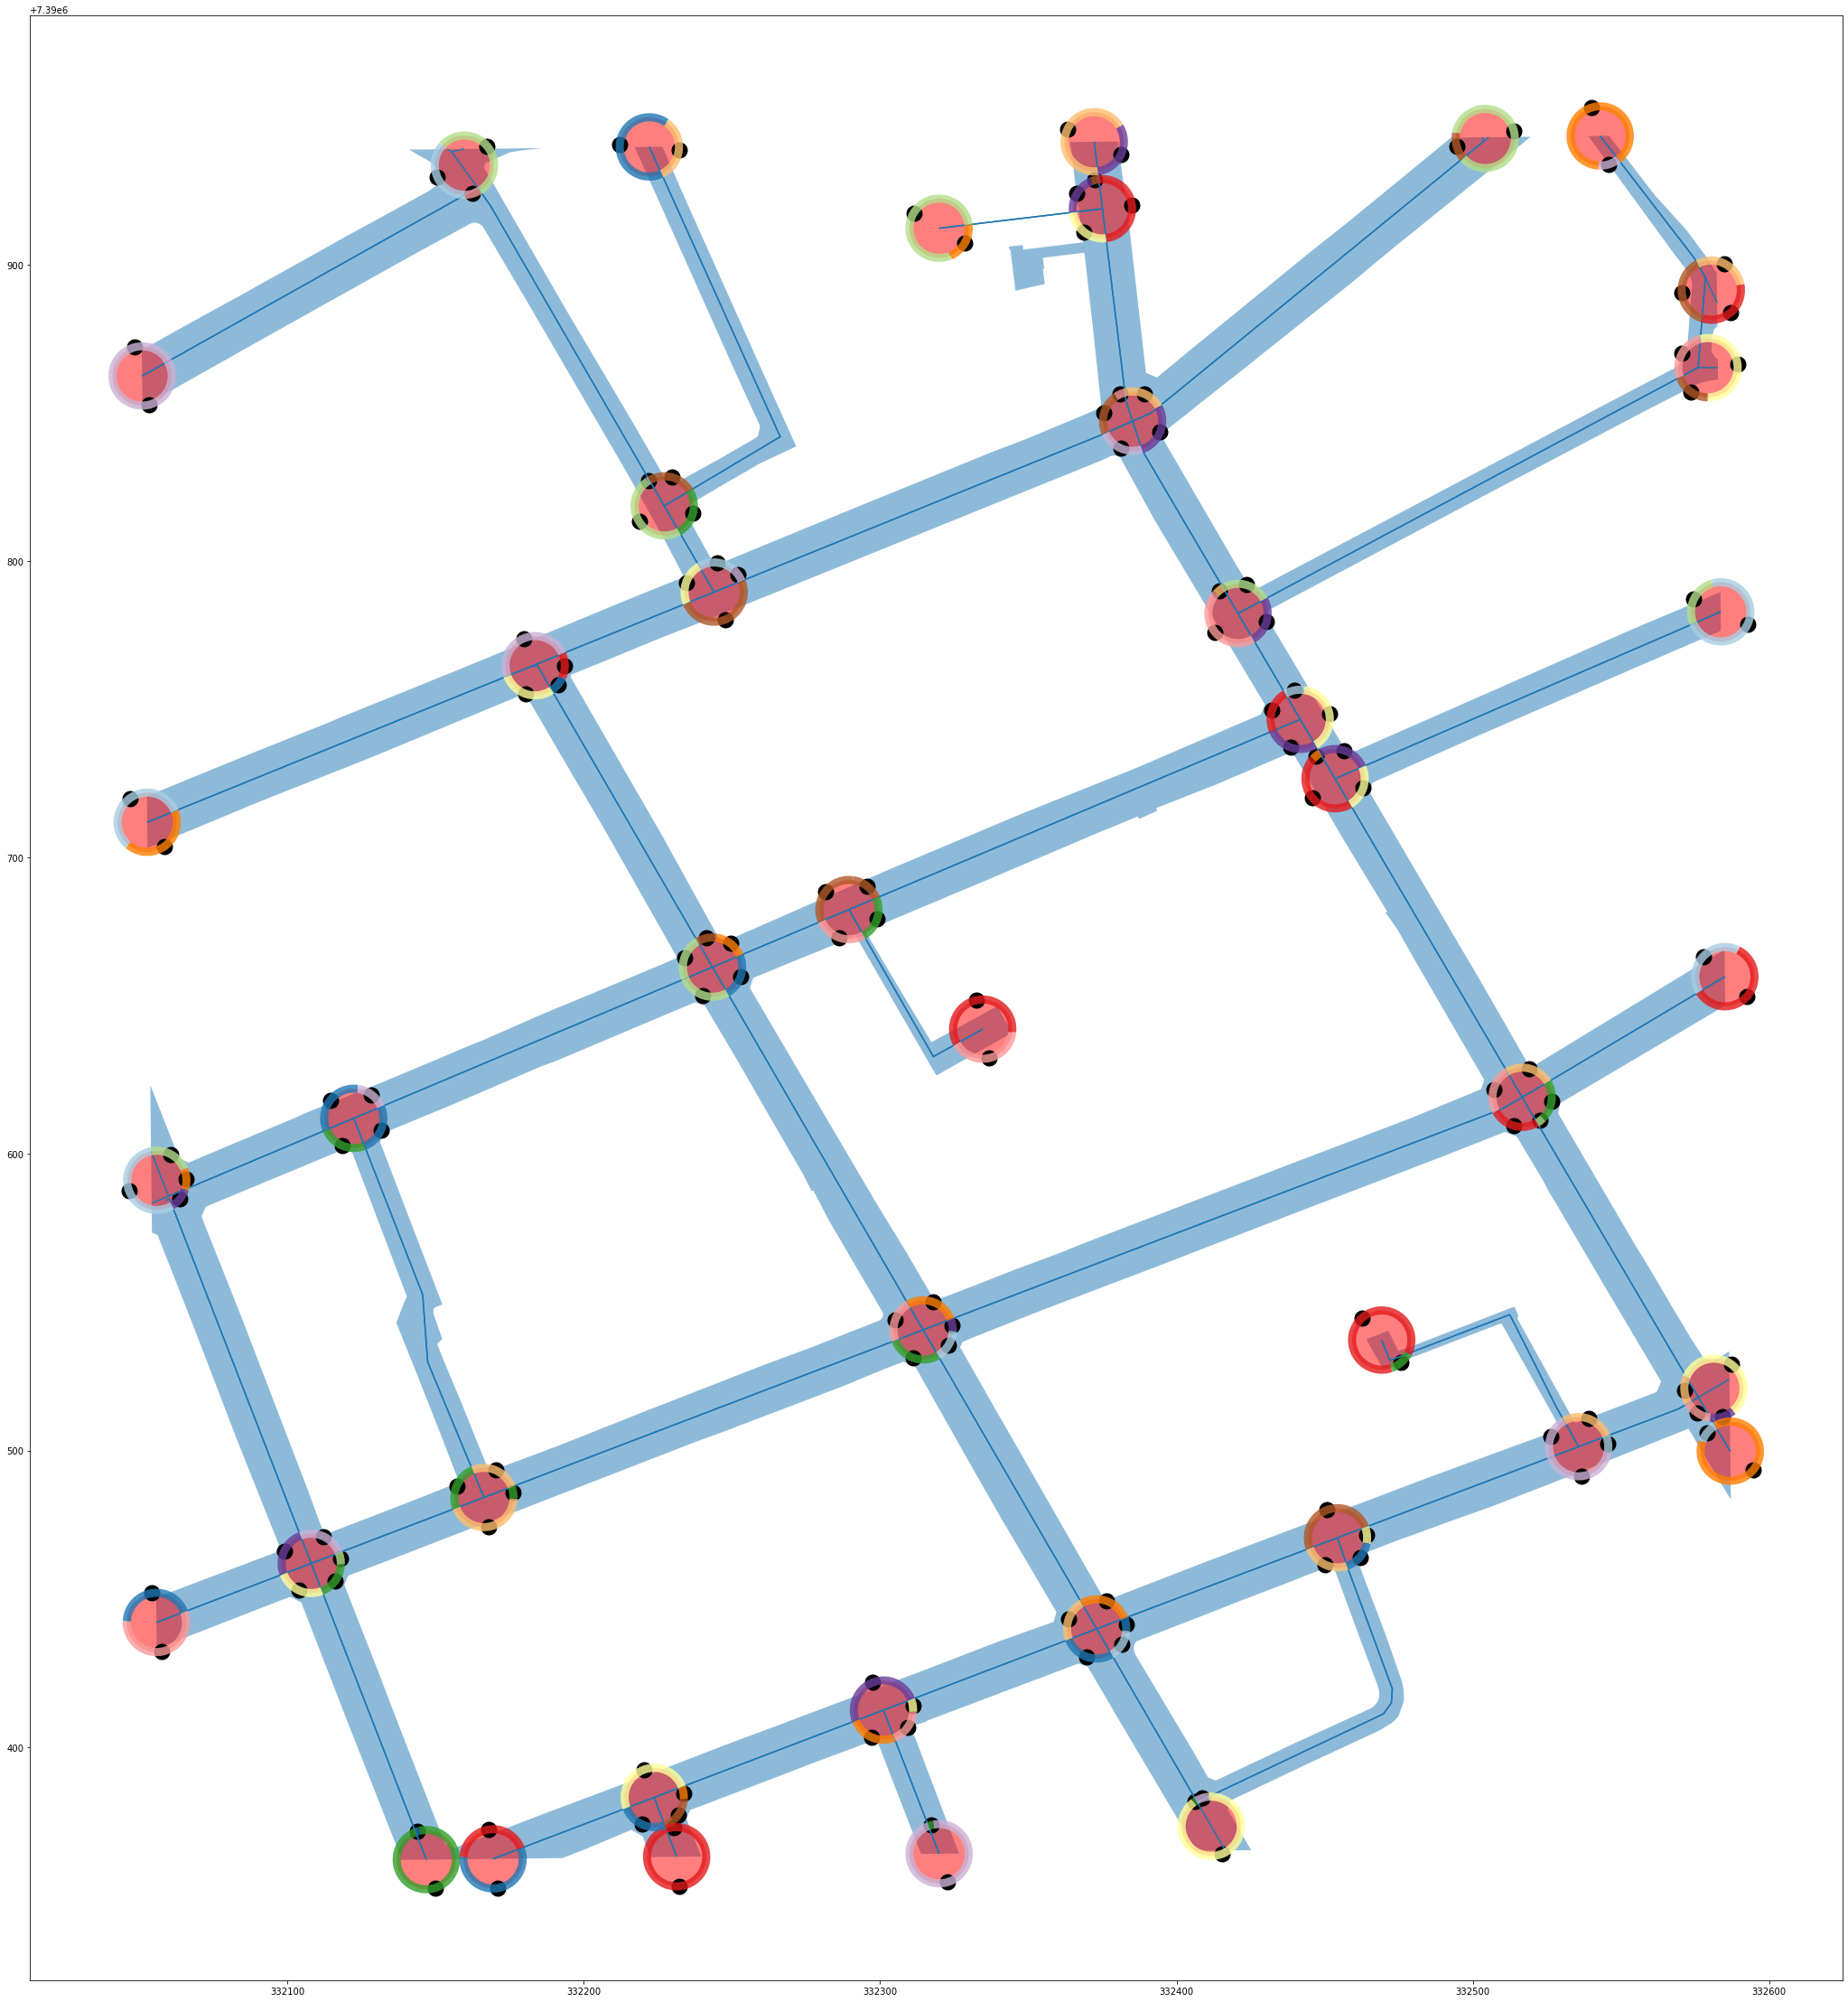

Wall time: 1.33 s


In [132]:
%%time

# importando a biblioteca pandas para poder concatenar
import pandas as pd

df_nos.crs = {'init': 'epsg:31983'}
# relacionando as tabelas
df_logradouros_nos = gpd.sjoin(df_logradouros, df_nos, how='left', op='intersects')

# dissolvendo as feições podemos ter uma feição de multiString por nó o que vai facilitar nos processamentos
# isolando apenas a coluna de geometria e modificando o nome dela já pensando em concatena-la
df_nos_logradouros = df_logradouros_nos.dissolve(by='index').iloc[:, 0:1]

# gerando a intersecção de pontos nas bordas dos polígonos de nós
inter_linha = [df_nos.iloc[i].geometry.intersection(f['geometry']) for i, f in df_nos_logradouros.iterrows()]
df_inter_linha = gpd.GeoDataFrame(df_nos_logradouros.index, geometry=inter_linha)

# gerando ponto na borda
inter_ponto_borda = [f['geometry'].intersection(df_nos.iloc[i].geometry.boundary) for i, f in df_nos_logradouros.iterrows()]
df_inter_ponto_borda = gpd.GeoDataFrame(df_nos_logradouros.index, geometry=inter_ponto_borda)

# definindo o ponto para rotacionar o nó de cruzamento para o ponto inicial dele coincidir com um ponto da circunferência
df_ponto_para_rotacionar = df_inter_ponto_borda.geometry.apply(lambda x: x if type(x) == type(Point(0,0)) else x[0])

# calculando o angulo para girar a feição do nó e fazer coincidir o ponto final com algum ponto de fragmanetação
angulos = [degrees(atan2(df_ponto_para_rotacionar.iloc[i].y - f.geometry.centroid.y, \
                         df_ponto_para_rotacionar.iloc[i].x - f.geometry.centroid.x)) \
                         for i, f in df_nos.iterrows()]

# rotacionando o nó de cruzamento
df_nos['geometry'] = [rotate(f['geometry'], angulos[i], origin=f['geometry'].centroid.coords[0]) for i, f in df_nos.iterrows()]

# cortando a borda do nó de cruzamento com as linhas de viário
no_bordas = [split(f.geometry.boundary, df_nos_logradouros.iloc[i].geometry) for i, f in df_nos.iterrows()]
df_no_bordas = gpd.GeoDataFrame(df_nos_logradouros.index, geometry=no_bordas)

#separando cada string em uma linha indexada pelo nó
df_fatias = df_no_bordas.geometry.apply(pd.Series) \
    .merge(df_no_bordas, right_index = True, left_index = True) \
    .drop(["geometry"], axis = 1) \
    .melt(id_vars = ['index'], value_name = "geometry")
gdf_fatias = gpd.GeoDataFrame(df_fatias['index'], geometry=df_fatias['geometry'])
gdf_fatias = gdf_fatias.dropna()

#gerando colunas aleatórias para servir de base para a cor na plotagem do mapa
import random
gdf_fatias['rnd'] = random.sample(range(len(gdf_fatias)), len(gdf_fatias))

#gerando o ponto médio na geometria
ponto_medio = [r.geometry.interpolate(0.5, normalized=True) for i, r in gdf_fatias.iterrows()]
df_ponto_medio = gpd.GeoDataFrame(list(range(len(ponto_medio))), geometry=ponto_medio)
df_ponto_medio.columns = ['index', 'geometry']


# gerando as linhas de corte a partir do centroide do nó de cruzamento central

########################### REFATORAR
##from shapely.ops import cascaded_union, unary_union
##df_nos_concatenado['qt_pontos'] = df_nos_concatenado['novas_linhas'].map(lambda x: len(x))
##df_nos_concatenado[df_nos_concatenado['qt_pontos'] > 1]
##fatiado = [split(r.geometry.boundary, cascaded_union(r['novas_linhas'])) for i, r in df_nos_concatenado[df_nos_concatenado['qt_pontos'] > 1].iterrows()]
##fatias = [cascaded_union(fatia) for fatia in fatiado]
##df_fatiado = gpd.GeoDataFrame(list(range(len(fatias))), geometry=fatias)
##df_fatiado.columns = ['index', 'geometry']


f, ax = plt.subplots(1)

# Aplicando o zoom
#plt.margins(x=-0.30, y=-0.40)

df_vias.plot(ax=ax, alpha=0.5)
df_nos_logradouros.plot(ax=ax)
df_nos.plot(ax=ax, alpha=0.5, color='red')
gdf_fatias.plot(ax=ax, column='rnd', lw=9, cmap='Paired', alpha=0.8)
#df_inter_linha.plot(ax=ax, color='black', lw=8)
#df_inter_ponto_borda.plot(ax=ax, color='green', lw=8)
df_ponto_medio.plot(ax=ax, color='black', lw=12, alpha=1)

plt.show()
